# NSE CDF Analysis

Quick analysis of Mamba model NSE performance on test set.

In [6]:
from transfer_learning_publication.evaluation import MetricCalculator
import polars as pl
import matplotlib.pyplot as plt

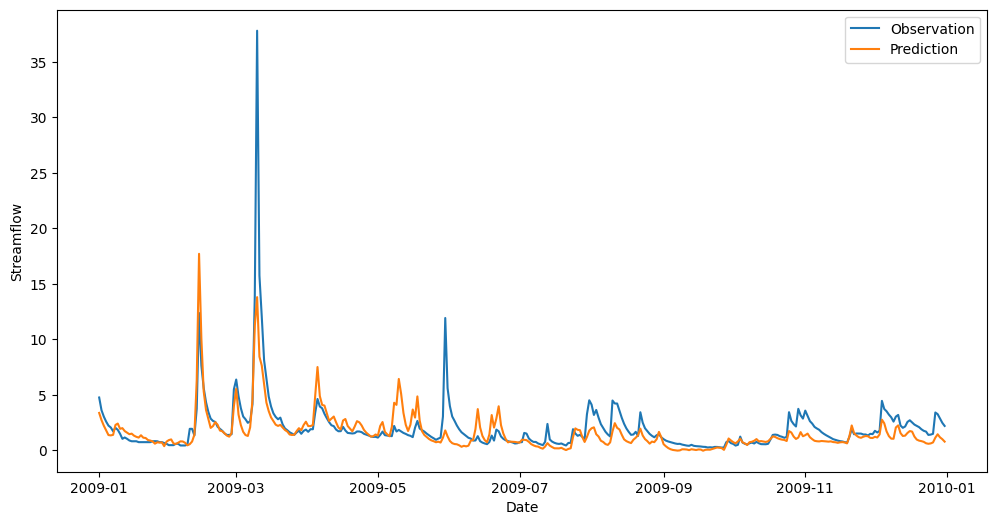

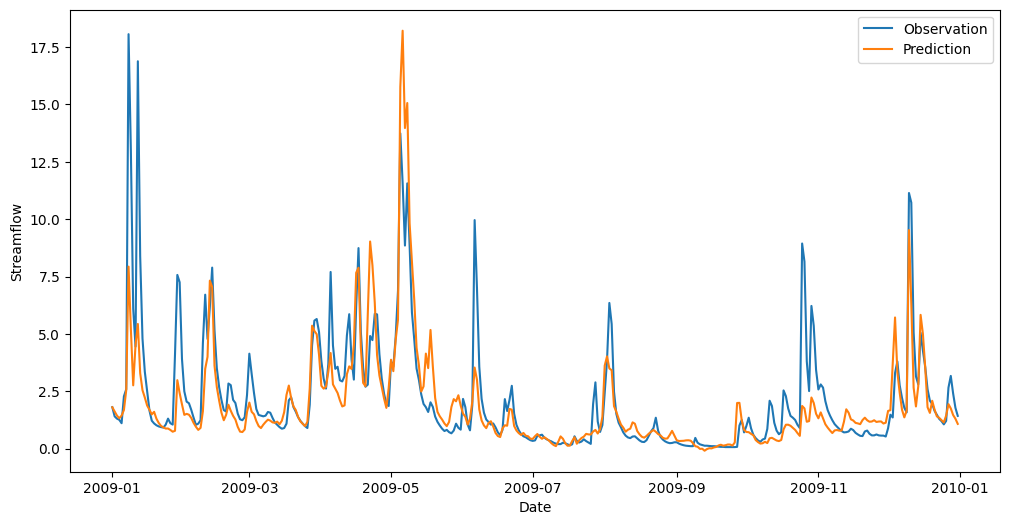

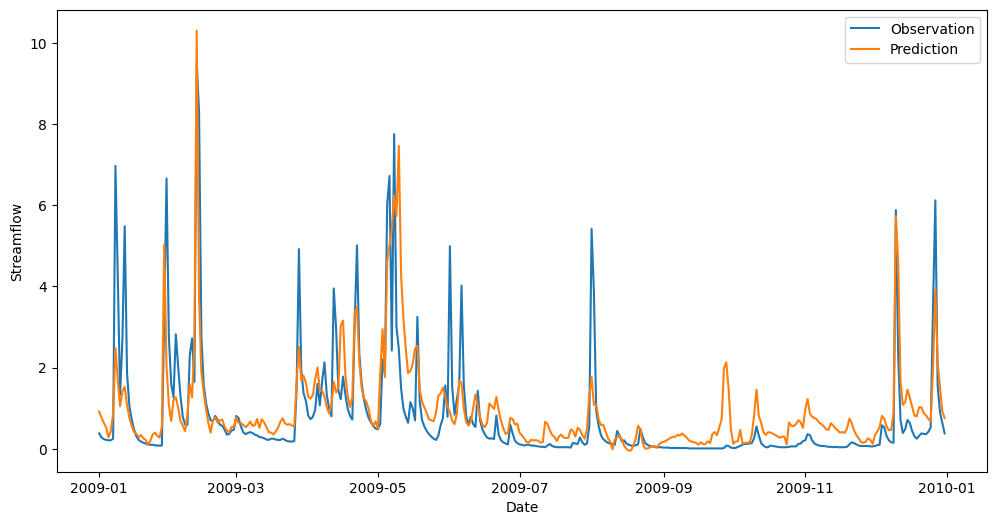

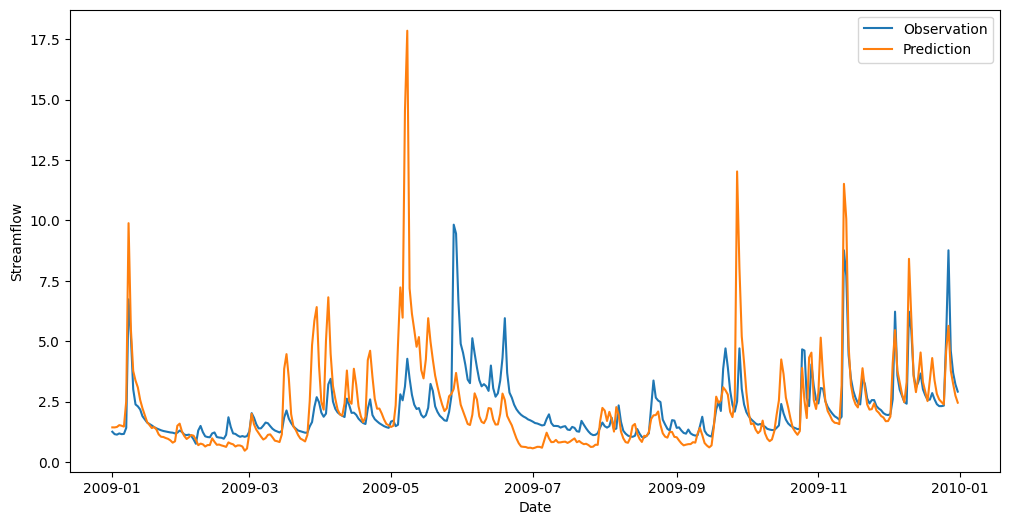

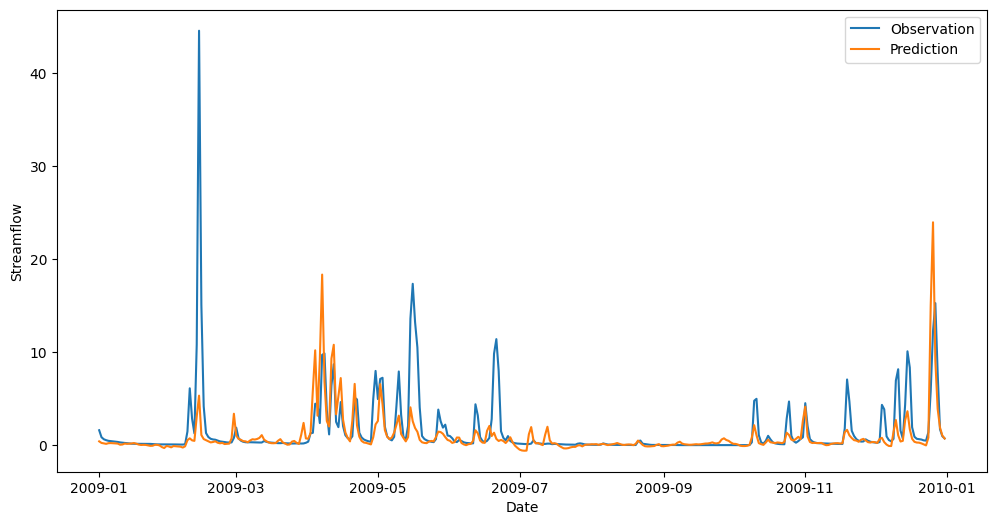

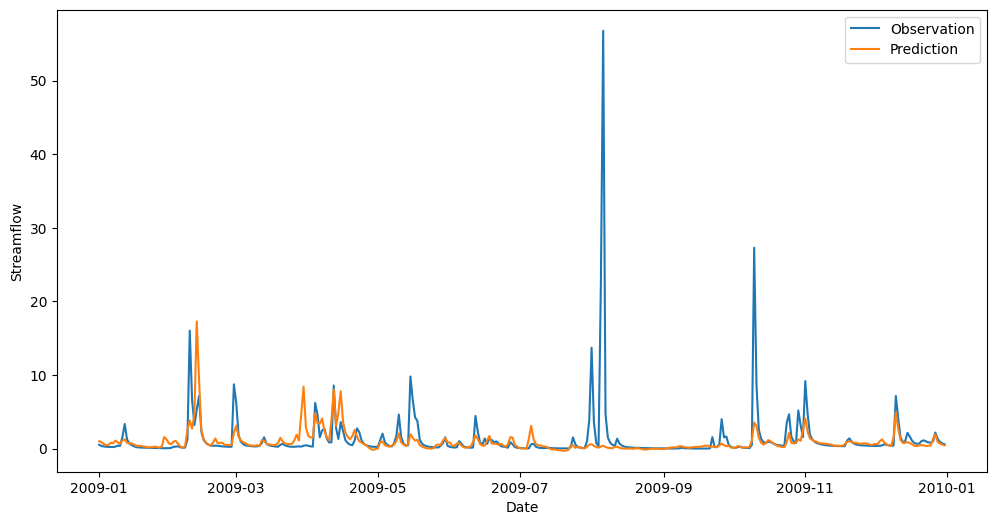

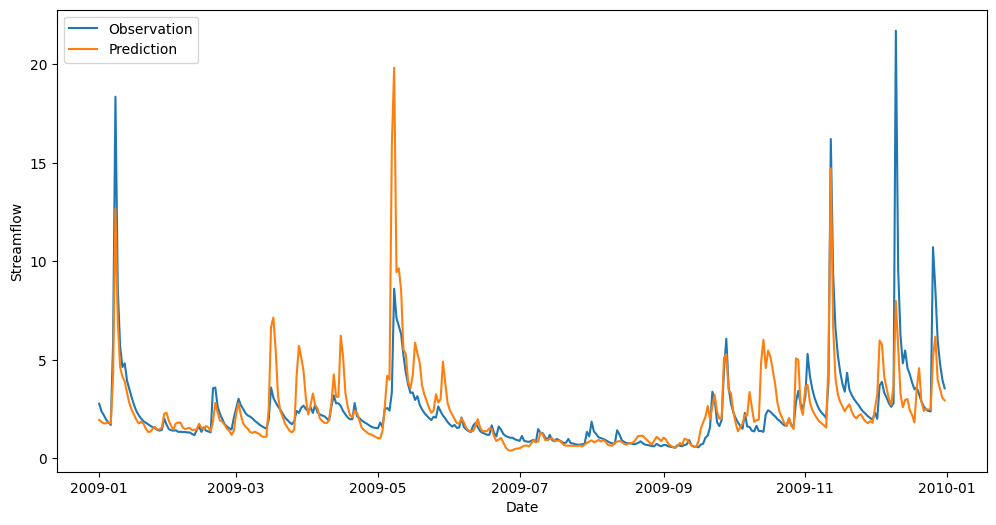

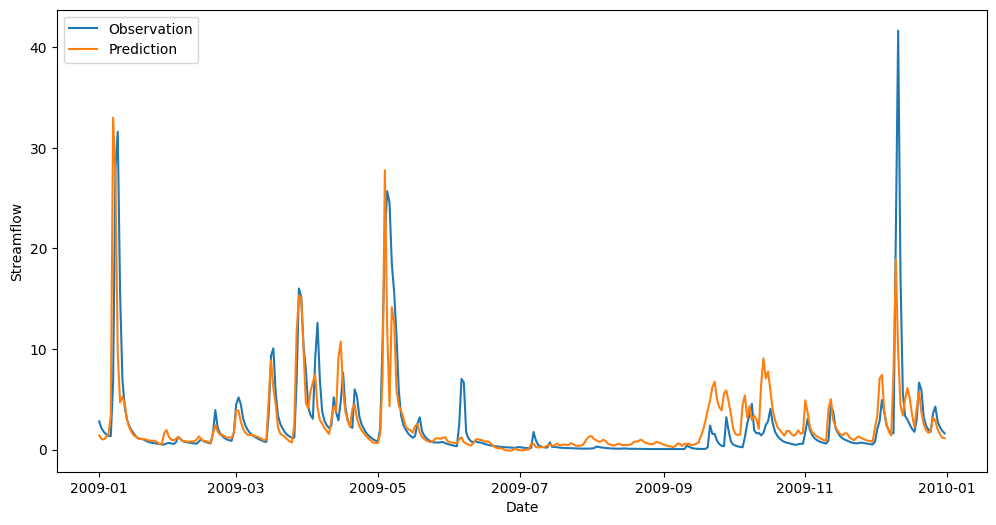

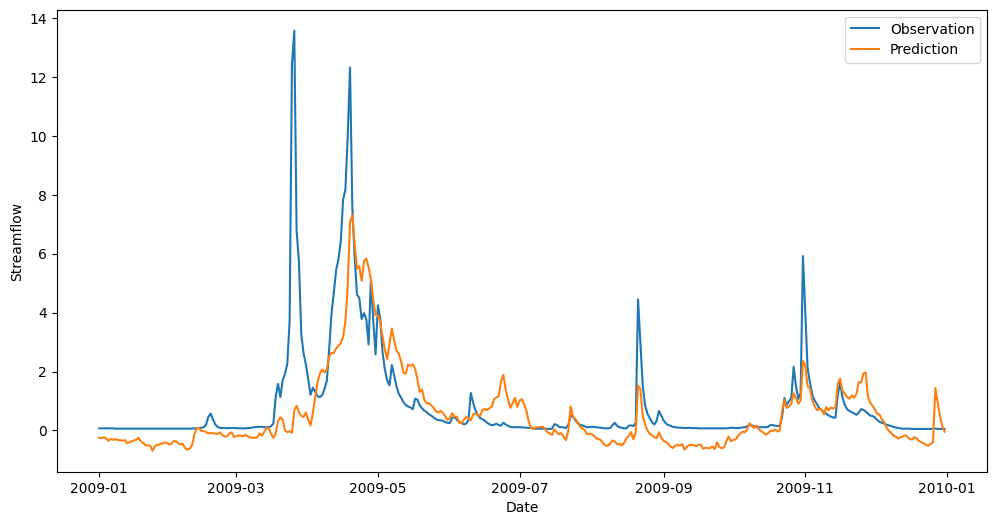

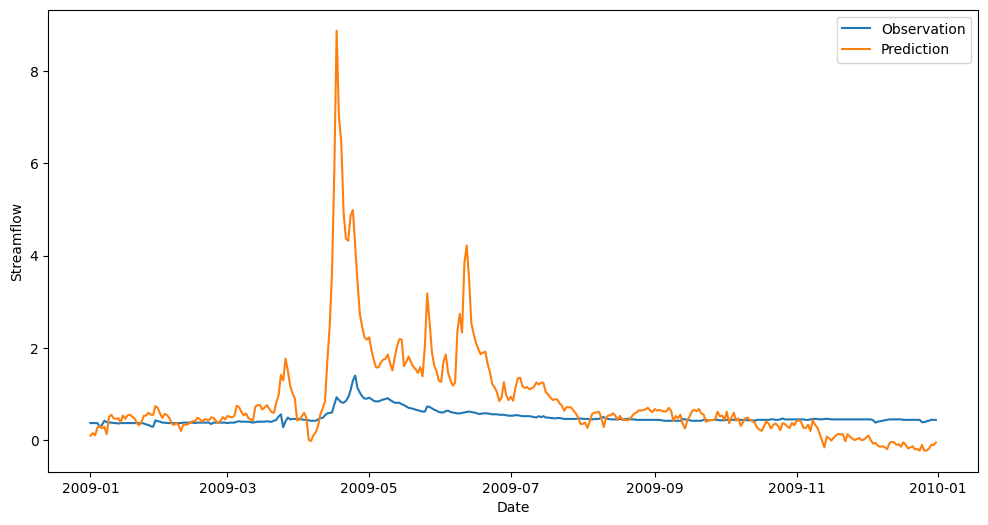

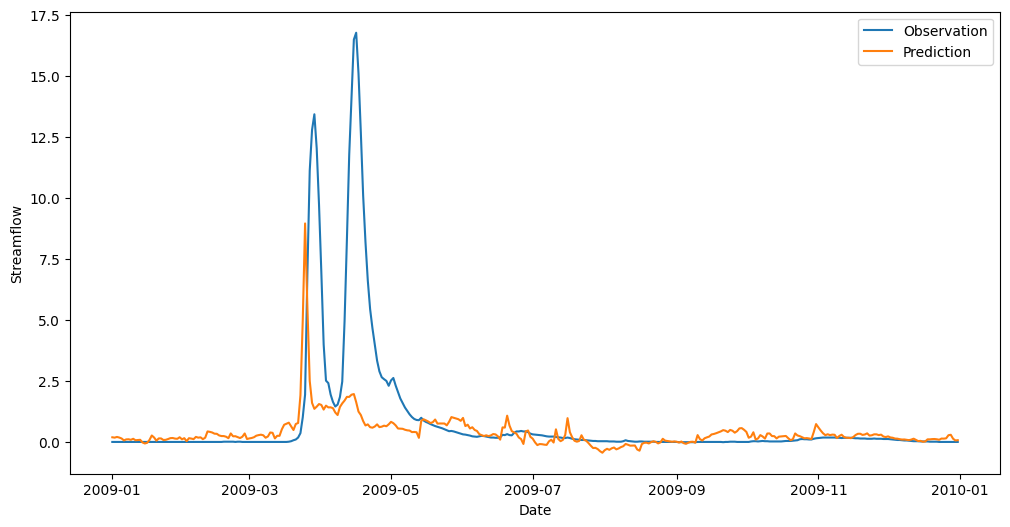

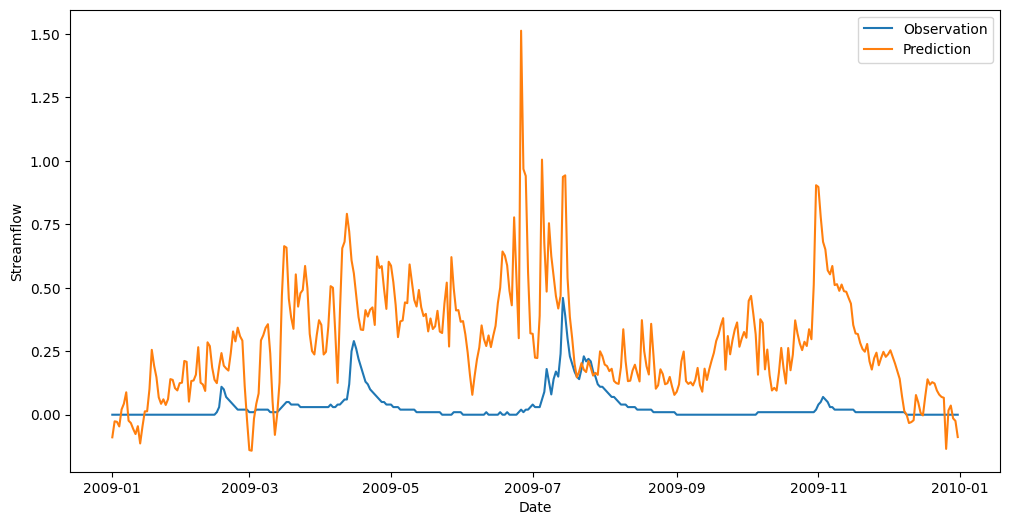

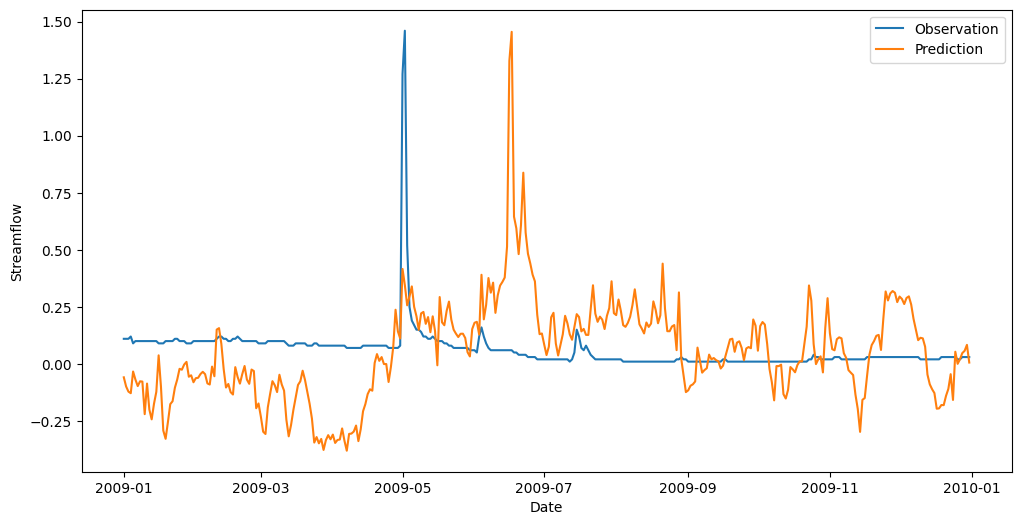

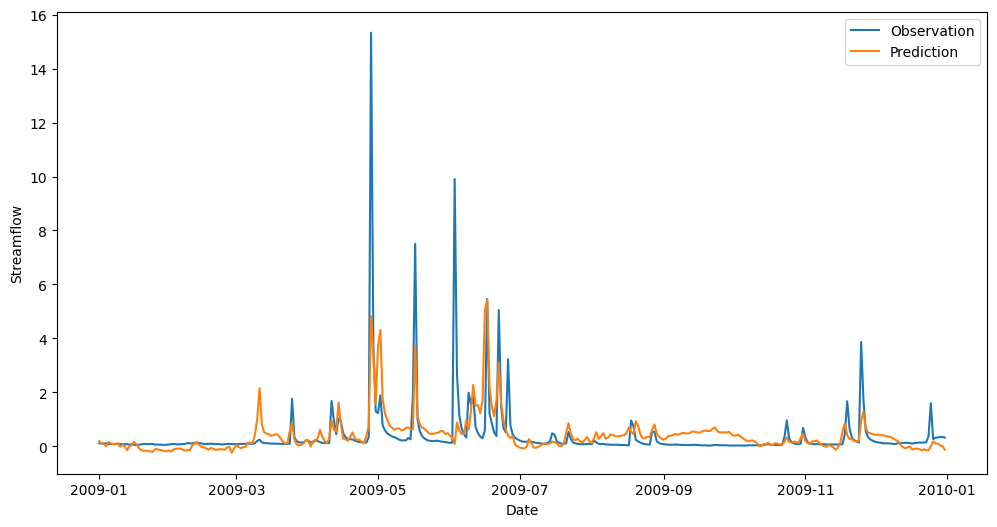

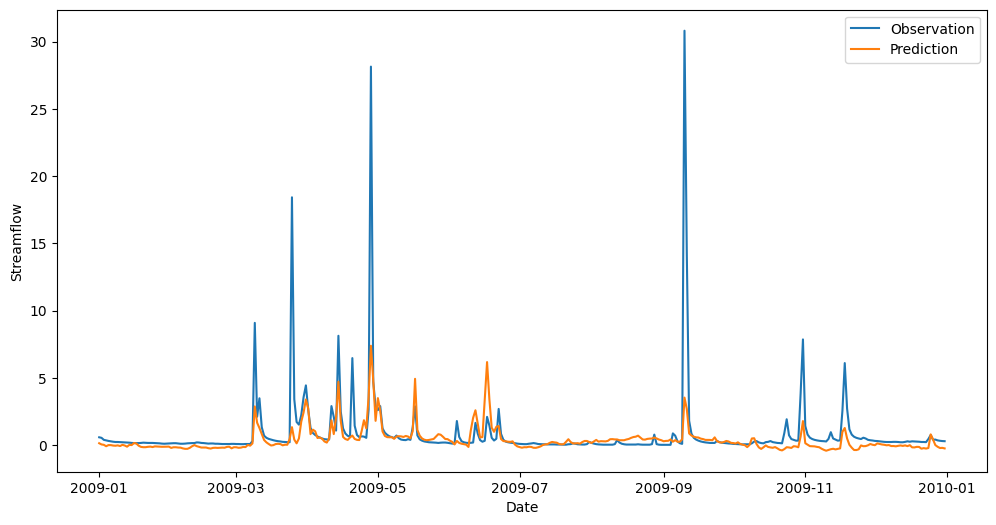

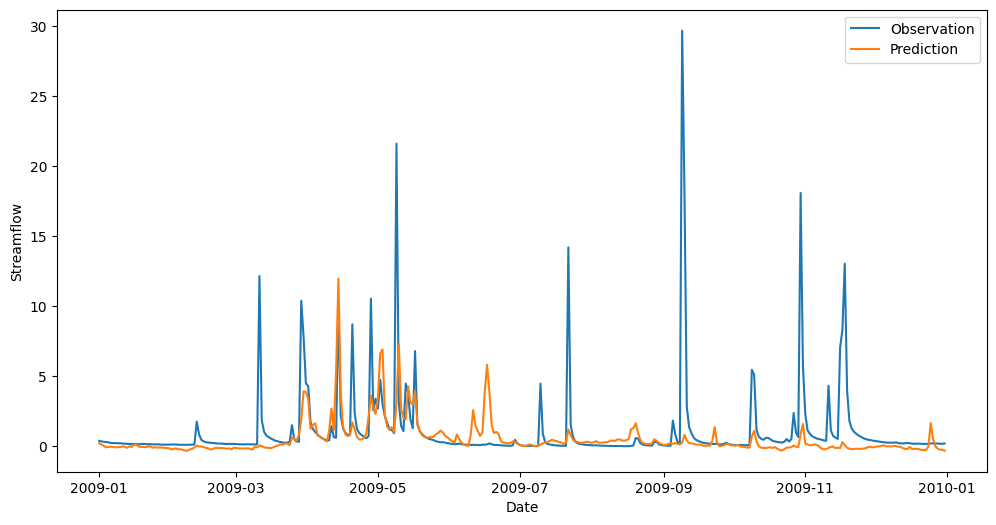

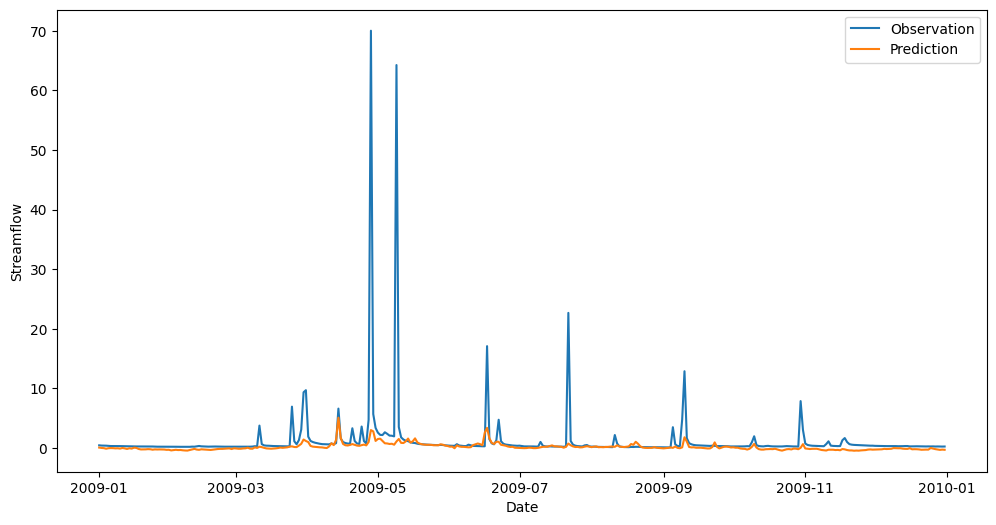

In [11]:
data = pl.read_parquet("/Users/nicolaslazaro/Desktop/work/pub-usa/results/evaluation/eval_2025-10-29_100707/model_name=ealstm_275k_fold_7/seed=42/predictions.parquet")
data


ids = ["camels_03028000",
       "camels_03069500",
       "camels_03159540",
       "camels_03161000",
       "camels_03346000",
       "camels_03366500",
       "camels_03460000",
       "camels_03574500",
       "camels_04015330",
       "camels_06431500",
       "camels_06470800",
       "camels_06477500",
       "camels_06853800",
       "camels_06885500",
       "camels_06910800",
       "camels_07167500",
       "camels_07180500"]

for gid in ids:
    subset = data.filter(
        (pl.col("group_identifier") == gid) &
        (pl.col("model_name") == "ealstm_275k_fold_7") &
        (pl.col("prediction_date").dt.year() > 2008) &
        (pl.col("prediction_date").dt.year() < 2010)
    )

    plt.figure(figsize=(12, 6))
    plt.plot(subset["prediction_date"].to_numpy(), subset["observation"].to_numpy(), label="Observation")
    plt.plot(subset["prediction_date"].to_numpy(), subset["prediction"].to_numpy(), label="Prediction")
    plt.xlabel("Date")
    plt.ylabel("Streamflow")
    plt.legend()
    plt.show()

## Load predictions and compute NSE

In [8]:
# Load predictions from parquet file
calc = MetricCalculator.from_parquet(
    "/Users/nicolaslazaro/Desktop/work/pub-usa/results/evaluation/eval_2025-10-29_100707/model_name=ealstm_275k_fold_7/seed=42/predictions.parquet"
)

# Compute LogNSE per basin (simulation mode, so all lead_time=1)
metrics = calc.compute_metrics(
    metrics=["nse"],
    exclude_filled=True,  # Only real observations
    group_by=["model_name", "group_identifier"]
)

print(f"NSE computed for {metrics.height} basins")
metrics.head()

NSE computed for 51 basins


model_name,group_identifier,NSE
str,str,f64
"""ealstm_275k_fold_7""","""camels_01073000""",0.566701
"""ealstm_275k_fold_7""","""camels_01414500""",0.645022
"""ealstm_275k_fold_7""","""camels_01440400""",0.714465
"""ealstm_275k_fold_7""","""camels_01516500""",0.530109
"""ealstm_275k_fold_7""","""camels_01539000""",0.536394


## Summary statistics

In [9]:
# Remove NaN values (if any)
clean_metrics = metrics.filter(~pl.col("NSE").is_nan())

print(f"Valid NSE values: {clean_metrics.height}")
print(f"\nNSE Statistics:")
print(clean_metrics.select("NSE").describe())

Valid NSE values: 51

NSE Statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ NSE           │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 51.0          │
│ null_count ┆ 0.0           │
│ mean       ┆ -231.344142   │
│ std        ┆ 1648.55746    │
│ min        ┆ -11773.540451 │
│ 25%        ┆ 0.04709       │
│ 50%        ┆ 0.296655      │
│ 75%        ┆ 0.529514      │
│ max        ┆ 0.784479      │
└────────────┴───────────────┘


## CDF Plot

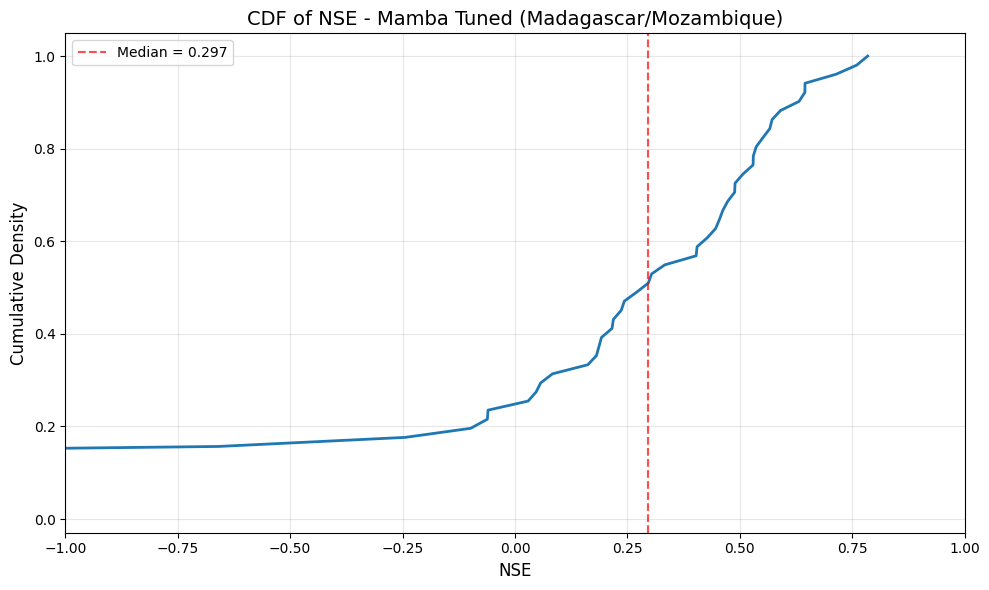


Median NSE: 0.297
Mean NSE: -231.344


In [10]:
# Get NSE values
nse_values = clean_metrics["NSE"].to_numpy()

# Sort for CDF
nse_sorted = sorted(nse_values)
n = len(nse_sorted)
cdf = [i / n for i in range(1, n + 1)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(nse_sorted, cdf, linewidth=2)
plt.xlabel("NSE", fontsize=12)
plt.ylabel("Cumulative Density", fontsize=12)
plt.title("CDF of NSE - Mamba Tuned (Madagascar/Mozambique)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim([-1, 1])

# Add median line
median_nse = clean_metrics["NSE"].median()
plt.axvline(median_nse, color='red', linestyle='--', alpha=0.7, label=f'Median = {median_nse:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nMedian NSE: {median_nse:.3f}")
print(f"Mean NSE: {clean_metrics['NSE'].mean():.3f}")